#Visual Coding - Neuropixels
Installing the allen institute SDK for reaching the visual coding data.

**Notice!** you must restart the kernel after finishing the allensdk installation, due to the change of the pandas version

In [ ]:
!pip install allensdk==2.9.0

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api.utilities import build_and_execute
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot

Mount your google drive, so you can save the cache files there and re-use them later. Make sure you have ~3GB free space on your chosen google drive account.
For doing that open the directory icon on the left panel, then go press on the drive button and on the pop window press "Connect to google drive".

In [ ]:
data_directory = '/content/drive/MyDrive/ecephys_cache/' # must be updated to a valid directory in your filesystem
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Downloading all the experiments info tables. Should take about ~5minutes on first execution. All the next executations of the following cell will be using the cached tables that are saved on your google drive account.

In [ ]:
session_id = 719161530
session = cache.get_session_data(session_id)

In [ ]:
cache.get_session_table().head()

###Brain Areas
Dictionary for specifying the areas code names according to visual parts

In [ ]:
brain_areas = {
    'visual_cortex': ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam'],
    'hippocampal_formation': ['CA1', 'CA3', 'DG', 'SUB', 'ProS'],
    'thalamus': ['LGd', 'LP'],
    'midbrain': ['APN']
}

###Picking Units (clustered neurons)

Show the units found by the Kilosort2 algorithm for spike sorting. These units represent neurons in the vicinity of the neuropixels probes.
For the following analyses we'll use only units with SNR (signal to noise ratio) higher than 1.5.

In [ ]:
area = 'LGd'
area_units = session.units.query(f'ecephys_structure_acronym=="{area}"')
print(f'Total units in {area}: {len(area_units)}')
high_snr_units = area_units.query('snr > 2')
print(f'Total units with SNR>2 in {area}: {len(high_snr_units)}\n')
high_snr_units.sort_values(by='snr', ascending=False).head()

##Stimulus Presentations

Show all the stimulus presentations in the session. Presentation is one trial of a stimulus. Notice that different presentation IDs can have equal conditions, meaning all stimulus metrics are the same.

In [ ]:
session.stimulus_presentations.head()

###Spike times for specific stimulus

In [ ]:
stimulus_name = 'gabors'

presentation_ids = session.stimulus_presentations.query(f'stimulus_name == "{stimulus_name}"').index.values

spike_times = session.presentationwise_spike_times(
    stimulus_presentation_ids=presentation_ids,
    unit_ids=high_snr_units.index
)

spike_times.head()

###Raster plot for a single neuron 

In [ ]:
metric = 'x_position'
unit_id = 950951194
unit_df = pd.merge(spike_times.query(f'unit_id=={unit_id}'), session.stimulus_presentations, left_on="stimulus_presentation_id", right_index=True)

plt.figure(figsize=(20,10))
end_time = unit_df.time_since_stimulus_presentation_onset.max()
raster = []

unit_df.loc[:, metric] = unit_df.query(f'{metric}!="null"')[metric].astype('float64')

metric_values = sorted([m for m in unit_df[metric].unique() if m != 'null'])
for m in metric_values:
  metric_df = unit_df.query(f'{metric}=={m}')
  for i, (presentation_id, group_idx) in enumerate(metric_df.groupby('stimulus_presentation_id').groups.items()):
    bins = np.arange(0, end_time, 0.001)
    hist, bins = np.histogram(metric_df.loc[group_idx, 'time_since_stimulus_presentation_onset'], bins=bins, range=(0, end_time))
    raster.append(hist)

raster = np.vstack(raster)
plt.figure(figsize=(20, 7))
offset = 35
plt.imshow(raster, aspect='auto', cmap='binary', interpolation='none', 
           extent=[0, end_time, min(metric_values) - offset, max(metric_values) + offset], origin='lower')
plt.xlabel('time [sec]')
plt.ylabel(metric)
plt.xlim([0, min(end_time, 1)])
plt.gca().set_yticklabels([min(metric_values) - offset] + metric_values)
plt.title(f'Raster Plot for Unit {unit_id} with metric {metric}')
plt.show()

###Peri-Stimulus Time Histogram (PSTH)
Histogram of neuron's firing rate through a repeated stimulus

In [ ]:
metric = 'x_position'
unit_id = 950951194
stimulus_df = session.get_stimulus_table('gabors')
stimulus_df.loc[:, metric] = stimulus_df.query(f'{metric}!="null"')[metric].astype('float64')
metric_values = sorted([m for m in stimulus_df[metric].unique()])
time_bin_edges = np.linspace(-0.01, 0.4, 200) # create 200 equal bins between -0.01 and 0.4

cols = 3
rows = int(np.ceil(len(metric_values)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.flatten()
for i, m in enumerate(metric_values):
  m_presentation_ids = stimulus_df.query(f'{metric}=={m}').index.values  
  spike_counts_da = session.presentationwise_spike_counts(
      bin_edges=time_bin_edges,
      stimulus_presentation_ids=m_presentation_ids,
      unit_ids=[unit_id]
  )
  psth = spike_counts_da.mean(dim='stimulus_presentation_id')
  axes[i].plot(time_bin_edges[:-1], psth)
  axes[i].set_title(f'{m}')
  axes[i].set_ylim([0, 0.13])

fig.tight_layout()

###Extract metric condition statistics

In [ ]:
stats = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=presentation_ids,
    unit_ids=high_snr_units.index
)

# display the parameters associated with each condition
stats = pd.merge(stats, session.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)

stats.head()

In [ ]:
def tuning_curves(area, stimulus_name, metric, snr=2):
  area_units = session.units.query(f'ecephys_structure_acronym=="{area}" and snr > {snr}')
  presentation_ids = session.stimulus_presentations.query(f'stimulus_name == "{stimulus_name}"').index.values
  stats = session.conditionwise_spike_statistics(
      stimulus_presentation_ids=presentation_ids,
      unit_ids=area_units.index
  )
  stats = pd.merge(stats.query(f"stimulus_presentation_count >= 5"), 
                   session.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)
  stats = stats.query(f'{metric} != "null"')
  return stats.groupby(['unit_id', metric]).agg(
    spike_mean=('spike_mean', np.mean),
    spike_sem=('spike_sem', lambda grp: np.sqrt(sum(grp**2))/np.sqrt(len(grp)))
  )

  
def plot_tuning_curves(area, stimulus_name, metric, units2plot=30, cols=5):
  tc = tuning_curves(area, stimulus_name, metric)
  units = tc.index.get_level_values(0).unique()[:units2plot]
  
  rows = int(np.ceil(units2plot/cols))
  fig, axes = plt.subplots(rows, cols, figsize=(20, rows*4), constrained_layout=True)
  axes = axes.flatten()
  for i, unit in enumerate(units):
    u = tc.loc[unit].reset_index()
    sns.barplot(data=u, x=metric, y='spike_mean', yerr=u.spike_sem, ax=axes[i])
    axes[i].set_title(str(unit))

  fig.suptitle(f'Area: {area}, Stimulus: {stimulus_name}')

In [ ]:
plot_tuning_curves('VISp', 'drifting_gratings', 'orientation')

###Tuning in the Hippocampus

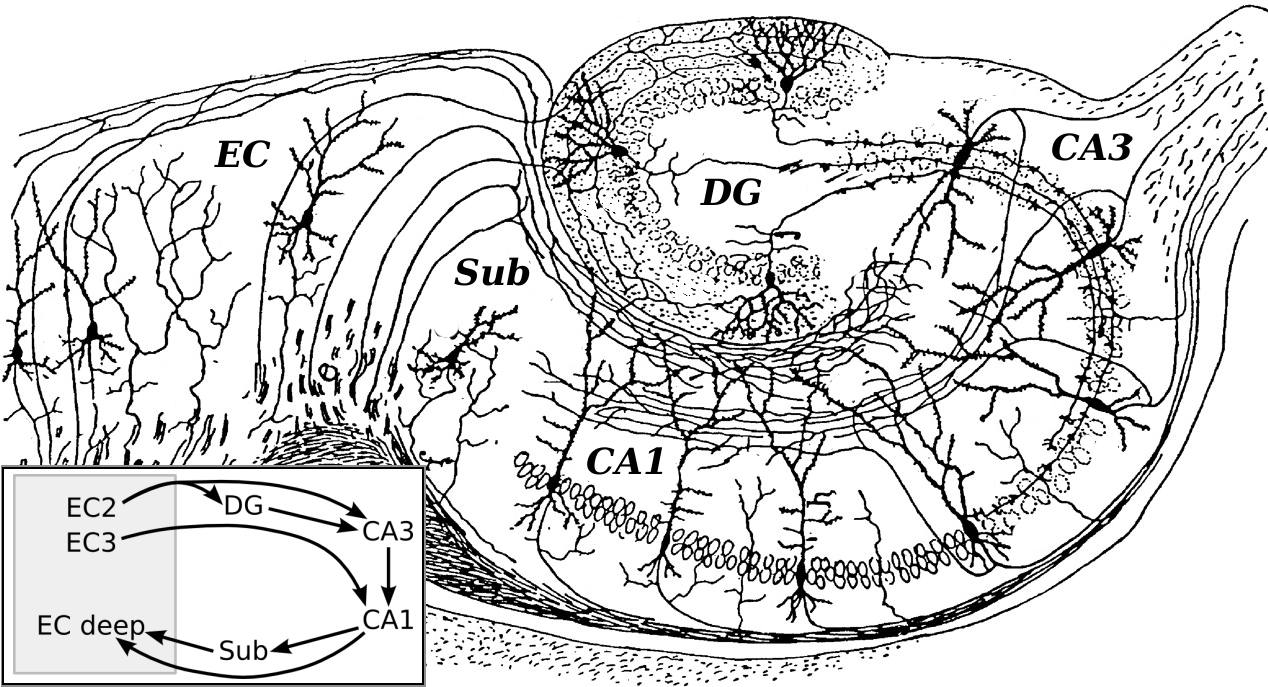

In [ ]:
plot_tuning_curves('CA1', 'drifting_gratings', 'temporal_frequency')

#Neural Correlations


###Covariance
Measure of how much 2 random variables vary together. It's similar to variance, but where variance tells you how a single variable varies, covariance tells you how 2 variables vary together.

image.png

positive covariance -> variables change in the same fashion.

negative covariance -> variables change differently.

0 covariance -> independent variables

In [ ]:
x = np.array([1,2,3,4,5])
y = np.array([5,4,3,2,1])
np.cov(x, y)[0, 1]

###Correlation
The covariance can be normalized to a score between -1 and 1 to make the magnitude interpretable by dividing it by the standard deviation of X and Y. The result is called the correlation of the variables, also called the Pearson correlation coefficient, named for the developer of the method.

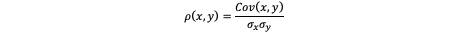

correlation can have any value in the range [-1, 1]. If 2 random variables are independent => correlation is 0 (though we can't infer the opposite way)

In [ ]:
np.corrcoef(x, y)

###Signal Correlation
Measures the correlation coefficient between mean responses to **different stimuli**. The measure is often used to quantify the extent to which a pair of neurons has similar tuning or other functional properties.
Decreases in this type of correlation, for instance through adaptation or contextual modulation, can lead to sparsening of population responses.

In [ ]:
tc = tuning_curves('VISp', 'drifting_gratings', 'orientation')
units = tc.index.get_level_values(0).unique()
metric_values = tc.index.get_level_values(1).unique()
sc = []
for unit in units:
  x = tc.loc[unit].spike_mean.to_numpy()
  if len(x) != len(metric_values):
    continue
  sc.append(x)

sc = np.vstack(sc)
plt.figure(figsize=(10, 10))
plt.imshow(np.corrcoef(sc), cmap='hot')
plt.colorbar(shrink=0.6)
plt.xticks(np.arange(len(units)), units, rotation=90)
plt.yticks(np.arange(len(units)), units)
plt.title('Signal Correlation')
plt.show()

###Noise Correlation
The Pearson's correlation coefficient of spike count responses to **repeated presentations of identical stimuli**, under the same behavioral conditions. Spike counts are typically measured over the timescale of a stimulus presentation or a behavioral trial, which range from a few hundered milliseconds to several seconds.


In [ ]:
unit1 = 950934597
unit2 = 950934614 
unit3 = 950935154

presentation_ids = session.stimulus_presentations.query(f'stimulus_name == "drifting_gratings"').index.values
stats = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=presentation_ids,
    unit_ids=[unit1, unit2, unit3]
)

fig, axes = plt.subplots(1,2, dpi=100)
sns.scatterplot(x=stats.loc[unit1].spike_mean, y=stats.loc[unit2].spike_mean, ax=axes[0])
axes[0].set_title('Neuron 1 vs Neuron 2')
sns.scatterplot(x=stats.loc[unit1].spike_mean, y=stats.loc[unit3].spike_mean, ax=axes[1])
axes[1].set_title('Neuron 1 vs Neuron 3')
fig.tight_layout()

In [ ]:
def noise_correlation(area, stimulus_name, snr=2):
  area_units = session.units.query(f'ecephys_structure_acronym=="{area}" and snr > {snr}')
  presentation_ids = session.stimulus_presentations.query(f'stimulus_name == "{stimulus_name}"').index.values
  stats = session.conditionwise_spike_statistics(
      stimulus_presentation_ids=presentation_ids,
      unit_ids=area_units.index
  )
  units = stats.index.get_level_values(0).unique()
  condition_ids = stats.index.get_level_values(1).unique()
  nc = []
  for u in units:
    x = stats.loc[u].spike_mean.to_numpy()
    if len(x) != len(condition_ids):
      continue
    nc.append(x)

  nc = np.vstack(nc)
  plt.figure(figsize=(10, 10))
  plt.imshow(np.corrcoef(nc), cmap='hot')
  plt.colorbar(shrink=0.6)
  plt.xticks(np.arange(len(units)), units, rotation=90)
  plt.yticks(np.arange(len(units)), units)
  plt.title('Noise Correlation')
  plt.show()


noise_correlation('VISp', 'drifting_gratings')